In [370]:
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import HexGrid, accept_tuple_argument
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors, path
from matplotlib.collections import RegularPolyCollection, transforms, PolyCollection
from matplotlib.markers import MarkerStyle
import numpy as np
import itertools

import village_life as vl

%matplotlib inline
from collections import namedtuple

import json

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(skill,' builds ', decision)? (village_life.py, line 173)

# Food generation

-  1 person needs 10 food
-  10 people run 1 farm
-  1 farm generates 100 food * fertility


-  people leave if totalfood < 10 * people


In [ ]:
key_map = [('food', 'farm', 'farmland')]

In [537]:
class Community():
    def __init__(self):
        self.population = np.random.randint(5, 100)
        self.food = np.random.randint(0, self.population)
        self.farms = 0
        #self.goods = np.random.randint(0, 1e3)
        #self.buildings = np.random.randint(0, 10)
        #self.trade = np.random.randint(0, 10)
        #self.defense = np.random.randint(0, 10)
        
class Village(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model, properties):
        super().__init__(unique_id, model)
        #self.wealth = 1
        #for k, v in properties.items():
        #    self.__setattr__(k, v)
        #print(properties)
        self.population = np.random.randint(5, 100)
        self.food = np.random.randint(0, self.population)
        self.farms = 0
        self.workers = 0
        
    def get(self, attribute):
        return self.__getattribute__(attribute)
    
    def update(self, attribute, value):
        self.__setattr__(attribute, value)
    
    def assign_workers(self, N, workplace):
        if (self.population-self.workers) >=N:
            #print(self.population, self.get(workplace),end=', ')
            self.workers += N
            self.update(workplace, self.get(workplace)+1)
            #print(self.get(workplace))
            
    def produce(self, resource, building, hex_key, production):
        x, y = self.pos
        #print(x,y)
        mod = self.model.grid.grid[x][y].prop.get(hex_key)/100 
        old_resource = self.get(resource)
        N = self.get(building)*production
        self.update(resource, old_resource+N*mod+ np.random.randn()*N/2)
        
        
    def step(self):
        if self.population == 0:
            return
        self.assign_workers(10, 'farms')
        self.produce('food', 'farms',  'farmland', 10)
        
        if self.food/self.population < 10:
            #print(self.food/self.population)
            try:
                other_agent = self.random.choice(self.model.schedule.agents)
                leave_N = np.random.randint(0, self.population-self.workers+1)
                other_agent.population += leave_N
                self.population -= leave_N
                #print(leave_N)
                #return leave_N
            except ValueError as err:
                print('Error', err, self.food, self.population, self.food/self.population, 
                      self.food%10+1, self.food%10, self.population-self.food/10)

        
        
class Kingdom(Model):
    """A model with some number of agents."""
    def __init__(self, N, hexmap):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        self.grid = FancyHexGrid(N, False, Village, hexmap)
        # Create agents
        for i in range(self.num_agents):
            a = Village(i, self, Community().__dict__)
            self.schedule.add(a)
            self.grid.place_agent(a, self.grid.find_empty())
        #print(self.grid.grid)
    
    def update_totals(self):
        self.totalfood = 0
        self.totalpop = 0
        for a in self.schedule.agents:
            self.totalfood += a.food
            self.totalpop += a.population
        return self.totalfood, self.totalpop
        
    
    def fix_food(self):
        self.update_totals()
        print('total food in kingdom: ', self.totalfood/25, self.totalpop)
        print('Sufficient food in kingdom: ', self.totalfood/25 >= self.totalpop)
        if self.totalfood/25 >= self.totalpop:
            return
        while self.totalfood/25 < self.totalpop:
            a = self.random.choice(self.schedule.agents)
            a.food += np.random.randint(1, (self.totalpop+1)*25-self.totalfood)
            self.update_totals()

        print('After update...')
        print('total food in kingdom: ', self.totalfood/25, self.totalpop)
        print('Sufficient food in kingdom: ', self.totalfood/25 >= self.totalpop)
        
    def get_agent_pos():
        return []
        

    def step(self):
        '''Advance the model by one step.'''
        self.schedule.step()
        #migrants = 0
        #print('Step', self.schedule.step())
        #return migrants
        #print(self.update_totals())
        
        

        
class FancyHexGrid(HexGrid):
    def __init__(self, N, torus, agent_type, hexlist):
        super().__init__(N, N, torus)
        #self.uninhabited = self.empties
        self.assign_props(hexlist)
        self.empties = [(c.prop.x, c.prop.y) for c in self.get_land()]
        
    def assign_props(self, hexlist):
        for c, x, y in self.coord_iter():
            #print(model.grid[x][y])
            self.grid[x][y].prop = (hexlist[x][y])
        #print(self.grid)
    
    def is_cell_empty(self, pos):
        """ Returns a bool of the contents of a cell. """
        #x, y = pos
        return any([isinstance(inst, agent_type) 
                    for inst in self.iter_cell_list_contents(pos) ])
        
        #return True if self.grid[x][y] == self.default_val() else False
    
    @staticmethod
    def default_val():
        """ Default value for new cell elements. """
        #return set() # None # HexProps(dict())
        return namedtuple('cell_content', ['prop', 'agent'])

    def _place_agent(self, pos, agent):
        """ Place the agent at the correct location. """
        x, y = pos
        #self.grid[x][y].add(agent)
        self.grid[x][y].agent=agent
        if pos in self.empties:
            self.empties.remove(pos)

    def _remove_agent(self, pos, agent):
        """ Remove the agent from the given location. """
        x, y = pos
        #self.grid[x][y].remove(agent)
        self.grid[x][y].agent = None
        if self.is_cell_empty(pos):
            self.empties.append(pos)

    @accept_tuple_argument
    def iter_cell_list_contents(self, cell_list):
        """
        Args:
            cell_list: Array-like of (x, y) tuples, or single tuple.

        Returns:
            A iterator of the contents of the cells identified in cell_list

        """
        return itertools.chain.from_iterable(
            self[x][y] for x, y in cell_list if not self.is_cell_empty((x, y)))
    
    def get_prop_list(self, prop):
        return [c.prop.__getattribute__(prop) for c in self]
    
    
    def get_prop_grid(self, prop):
        p = self.get_prop_list(prop)
        return np.reshape(np.array(p), (self.width, self.width))
    
    def get_oceans(self):
        return [c for c in self if c.prop.type=='ocean']
    
    def get_land(self):
        return [c for c in self if c.prop.type=='land']
    
    def get_agents(self):
        return [c.agent for c in self if not isinstance(c.agent, property)]
    
    def plot_prop(self, prop, cmap=plt.cm.viridis, edgecolor=None, **kwargs):
        '''
        Parameters
        ---------------
        edgecolor : str, colortuple, None
            must be valid colorname or tuple; if None edgecolor=facecolor=cmap
        '''
        proplist = np.array(self.get_prop_list(prop))
        offsets = []
        N = self.width
        for col in range(N):
            if col%2 == 0:
                for row in range(N):
                    #print(row,col)
                    offsets.append([row, col])
            else:
                for row in range(N):
                    #print(row,col+0.5)
                    offsets.append([row+0.5, col])

        offsets = np.array(offsets)

        #facecolors = [cmap(x) for x in proplist/proplist.max()]
        #cbounds = np.linspace(proplist.min(), proplist.max(), 10)
        #print(cbounds)
        #global norm
        norm = None # mcolors.BoundaryNorm(boundaries=cbounds, ncolors=10)
        #norm.autoscale_None(proplist)
        if edgecolor is None:
            edgecolor = facecolors

        fig, ax = plt.subplots(1,1, figsize=(10,10))

        polygon = np.zeros((6, 2), float)
        polygon[:, 0] = np.array([0.5, 0.5, 0.0, -0.5, -0.5, 0.0])
        polygon[:, 1] = np.array([-0.5, 0.5, 1.0, 0.5, -0.5, -1.0])* 2/3.0
        #global collection

        collection = PolyCollection(
                        [polygon],
                        edgecolors='w',
                        #facecolors=facecolors,
                        offsets=offsets,
                        transOffset=transforms.IdentityTransform(),
                        offset_position="data",
                        norm=norm,
                        cmap=cmap                
                        )
        print(collection.get_cmap().name, collection.get_array())
        collection.set_array(proplist)
        #collection.autoscale()
        #collection.set_cmap(cmap)
        ax.add_collection(collection, autolim=False)
        ax.axis('square')
        ax.set_xlim(-1,N+1)
        ax.set_ylim(-1,N+1)
        #global mappable
        #
        mappable = plt.cm.ScalarMappable(norm=collection.norm, cmap=collection.cmap)
        mappable.set_array(collection.get_array())
        fig.colorbar(mappable, ax=ax)
        return fig
    
    
    def plot_agent_prop(self, prop=None, ax=None, **kwargs):
        '''
        Make scatter plot of agent properties on hexmap. 
        Parameters:
        ------------
        prop : str, [None]
            valid attribute of agents on the grid, if None only position is shown
        ax : axes handle
            ax
        kwargs : 
            valid keywords for plt.scatter(), if not given 
            kwargs = dict(edgecolor='k', facecolor='none')
        
        '''
        #print('Kwargs', kwargs)
        ## Override some defaults, optimized for plotting on top of hexmap
        if 'edgecolor' not in kwargs.keys():
            kwargs['edgecolor'] = 'k'
        if 'facecolors' not in kwargs.keys():
            kwargs['facecolor'] = 'none'
            
        agents = self.get_agents()
                
        if prop is None or prop=='pos':
            aprop = None
        else:
            try:
                aprop = [float(a.__getattribute__(prop)) for a in agents]
            except AttributeError:
                a = agents[0]
                raise AttributeError(
                    '{} is not a valid property of agent {}. Select one of {}'.format(
                    prop, a.__class__, a.__dict__) )
                
        ## Modify positions for hex plot
        apos = [list(a.pos) for a in agents]     
        for i,pos in enumerate(apos):
            if pos[1]%2==1:
                apos[i][0] += 0.5
        apos = np.array(apos)
    
        if ax is None: fig, ax = plt.subplots(1,1)
        ax.scatter(apos[:,0], apos[:,1], s=aprop, **kwargs)
        return ax.figure
    
    
class HexProps:
    '''
    Container for hex field properties.
    
    Mainly assigns the properties captured in the 
    dictionary output of `hexgen` as attributes.
    '''
    def __init__(self, params):
        params = self._clean_hexgen_dict(params)
        biome = params.pop('biome')  # Is a subdict, thus set separately
        for k, v in params.items():
            #print(k,v)            
            self.__setattr__(k, v)
        
        ## Get biome stats from subdict
        for k in ['id', 'title', 'base_fertility']:
            self.__setattr__('biome_'+k, biome[k])
            
        self.biome_base_fertility /= 1.50
            
        #print(self.__dict__)
        #self.x = params['y']
        #self.y = params['x']
        self.population = 0
        self.farmland = self.biome_base_fertility
        self.generate_farmland()
            
    def _has_attr(self, attr):
        return attr in self.__dict__
    
    
    def _clean_hexgen_dict(self, params):
        if 'clean' in params.keys(): return
        
        params.pop('id')
        params.pop('geoform')
        params.pop('colors')
        params.pop('edges')
        
        params['clean'] = True
        return params
    
    
    def get(self, attribute):
        return self.__getattribute__(attribute)
    
    def generate_farmland(self):
        #print('Generate farmland')
        self.farmland = 10*np.random.randn()+self.biome_base_fertility
        
    

In [546]:
with open('../hexgen/export_test.json', 'r') as f:
    params = json.load(f)

display(params['hexes'])
#hexlist = [HexProps(h) for l in params['hexes'] for h in l]
hexlist = [[HexProps(h) for h in l ] for l in params['hexes']]
#hexlist

[[{'id': '81bf8345914b4abba24cbfb2a7a81008',
   'x': 0,
   'y': 0,
   'altitude': 148.0,
   'temperature': -12.24,
   'moisture': 17,
   'biome': {'id': 3,
    'code': 'p',
    'title': 'Alpine Tundra',
    'color': [97, 130, 106],
    'base_fertility': 10,
    'color_satellite': [59, 60, 42],
    'name': 'alpine_tundra'},
   'type': 'land',
   'is_inland': True,
   'is_coast': True,
   'geoform': '90c3b027222641f6b7cb98c3eaae950c',
   'colors': {'satellite': [111, 115, 79],
    'terrain': [223, 190, 144],
    'temperature': [85.0, 255.0, 255.0],
    'biome': [97, 130, 106],
    'rivers': [104, 158, 151]},
   'edges': {'east': {'is_river': False,
     'is_coast': False,
     'direction': 'south'},
    'north_east': {'is_river': False, 'is_coast': False, 'direction': 'south'},
    'north_west': {'is_river': False, 'is_coast': False, 'direction': 'south'},
    'west': {'is_river': False, 'is_coast': False, 'direction': 'south'},
    'south_west': {'is_river': False,
     'is_coast': Fals

(295, 502)
100


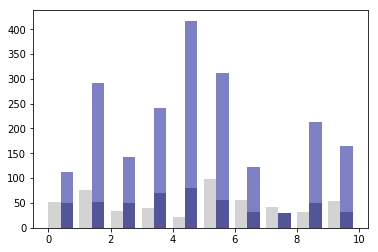

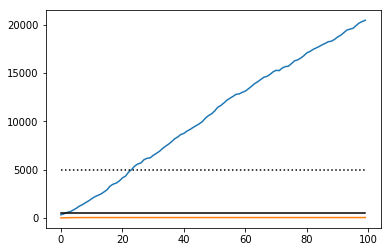

In [540]:
NSTEPS = 100
N = 10
model = Kingdom(N, hexlist)
#model.fix_food()
print(model.update_totals())

count = 0
x = []
y = []
for c in model.grid.coord_iter():
    x.append(c[1])
    y.append(c[2])
    count += 1
print(count)
#plt.plot(x, y, 'o')

xv = [a.pos[0] for a in model.schedule.agents]
yv = [a.pos[1] for a in model.schedule.agents]
#plt.plot(xv, yv, 's')

#N = 10
#model = Kingdom(N)
#model.fix_food()
plt.figure()
food = [a.food/10 for a in model.schedule.agents]
plt.bar(np.arange(model.num_agents), food, 0.4, align='edge', alpha=0.5, color='lightblue')

population = [a.population for a in model.schedule.agents]
plt.bar(np.arange(model.num_agents), population, 0.4, align='edge', color='lightgray')

food = list()
pop = list()
farms = list()
for i in range(NSTEPS):
    model.step()
    totals =model.update_totals() 
    food.append(totals[0])
    pop.append(totals[1])
    farms.append(np.sum(np.array([a.farms for a in model.schedule.agents])))
    

postfood = [a.food/10 for a in model.schedule.agents]
plt.bar(np.arange(model.num_agents)+0.4, postfood, 0.4, zorder=10, align='edge', alpha=0.5, color='darkblue')

population = [a.population for a in model.schedule.agents]
#plt.hist(population)
plt.bar(np.arange(model.num_agents)+0.4, population, 0.4, align='edge', color='darkgrey')

plt.figure()
t = np.arange(NSTEPS)
plt.plot(t, food)
plt.plot(t, np.array(pop)*10, ':k')
plt.plot(t, pop, 'k')
plt.plot(t, farms)
#plt.yscale('log')

(746147.8173598913, 558) 52


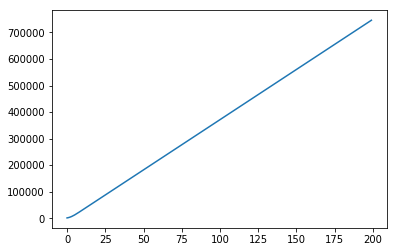

In [512]:
print(model.update_totals(), np.sum(np.array([a.farms for a in model.schedule.agents])))

plt.plot(t, food)
#food[-100:]

Greens None


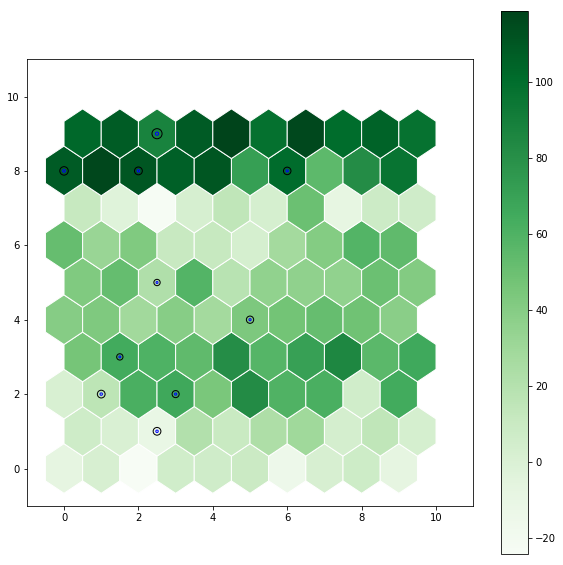

In [470]:
fig = model.grid.plot_prop('farmland', cmap=plt.cm.Greens, edgecolor='w')
ax = fig.get_axes()[0]
fig = model.grid.plot_agent_prop(prop='population', ax=ax)
fig = model.grid.plot_agent_prop(prop='farms', ax=ax, edgecolor='b')
#fig.colorbar()


Greens None


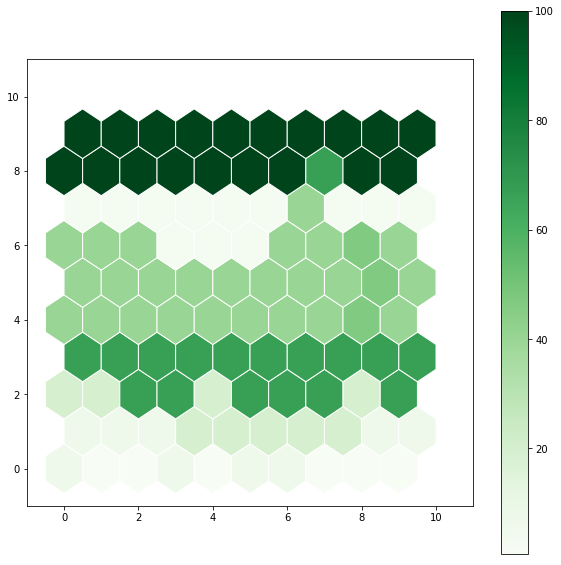

In [389]:
fig = model.grid.plot_prop('biome_base_fertility', cmap=plt.cm.Greens, edgecolor='w')

In [360]:
h = model.grid.grid[]

In [361]:
h = model.grid.grid[0][0]
hp = h.prop

In [362]:
hp.farmland

array([8.45170937])

In [364]:
np.random.randn(1)

array([0.66153956])

In [390]:
model.grid

{'parameters': {'map_type': {'id': 1,
   'title': 'Terran',
   'colors': [[-25, [0, 15, 120]],
    [-15, [0, 20, 130]],
    [0, [0, 20, 170]],
    [20, [56, 89, 22]],
    [50, [75, 112, 9]],
    [75, [129, 135, 42]],
    [100, [196, 150, 95]],
    [110, [223, 190, 144]],
    [120, [233, 200, 154]],
    [135, [243, 210, 164]],
    [140, [253, 220, 174]]],
   'name': 'terran'},
  'surface_pressure': 1013.25,
  'size': 10,
  'year_length': 365,
  'day_length': 24,
  'base_temp': 0,
  'avg_temp': 15,
  'sea_percent': 30,
  'hydrosphere': True,
  'ocean_type': {'id': 1, 'title': 'Water', 'name': 'water'},
  'random_seed': 123456,
  'roughness': 8,
  'height_range': [0, 255],
  'pressure': 1,
  'axial_tilt': 23,
  'craters': False,
  'volanoes': True,
  'num_rivers': 10,
  'num_territories': 0,
  'eport_type': 'png'},
 'details': {'size': 10,
  'sea_level': 44.0,
  'avg_height': 73.85,
  'max_height': 148.0,
  'min_height': 40.0},
 'hexes': [[{'x': 0,
    'y': 0,
    'altitude': 148.0,
    '